In [1]:
import numpy as np
from functools import reduce
from collections import namedtuple
from typing import List, Tuple, Union,Dict
import json
import re

MAXSIDE = 100
MAXAREA = 40 * 40
MAXPIXELS = 40 * 40 * 5

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src', 'arclang')))
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from image import Image, Point
from function import *
# from dsl import *

In [2]:
from typing import List, Any

class Node:
    def __init__(self, node_type: str, value: Any = None, children: List['Node'] = None):
        self.node_type = node_type
        self.value = value
        self.children = children or []

    def __repr__(self):
        return f"Node(type={self.node_type}, value={self.value}, children={self.children})"

    def format(self, indent=0):
        """
        Format the Node and its children into a readable string representation.
        
        :param indent: The current indentation level (default: 0)
        :return: A formatted string representation of the Node
        """
        indent_str = '    ' * indent
        result = f"{indent_str}Node(type={self.node_type}"
        
        if self.value is not None:
            result += f", value={self.value}"
        
        if self.children:
            result += ", children=[\n"
            for child in self.children:
                result += child.format(indent + 1) + ",\n"
            result += f"{indent_str}]"
        else:
            result += ", children=[]"
        
        result += ")"
        return result

    def show(self):
        """
        Print the formatted representation of the Node and its children.
        """
        print(self.format())

# Example usage:
# root_node = Node(...)  # Your root Node object
# root_node.print_formatted()

In [3]:
from typing import Dict, Any, Optional

class Symbol:
    def __init__(self, name: str, type: str, scope: str, value: Any = None):
        self.name = name
        self.type = type  # 'variable', 'function', etc.
        self.scope = scope
        self.value = value


class SymbolTable:
    def __init__(self):
        self.scopes: Dict[str, Dict[str, Symbol]] = {"global": {}}
        self.current_scope = "global"

    def enter_scope(self, scope_name: str):
        if scope_name not in self.scopes:
            self.scopes[scope_name] = {}
        self.current_scope = scope_name

    def exit_scope(self):
        self.current_scope = "global"

    def add_symbol(self, name: str, type: str, value: Any = None):
        symbol = Symbol(name, type, self.current_scope, value)
        self.scopes[self.current_scope][name] = symbol

    def lookup(self, name: str) -> Optional[Symbol]:
        if name in self.scopes[self.current_scope]:
            return self.scopes[self.current_scope][name]
        elif name in self.scopes["global"]:
            return self.scopes["global"][name]
        return None
    

In [4]:
import re
from typing import List, Tuple
class Parser:
    def __init__(self):
        self.symbol_table = SymbolTable()

    def parse(self, script: str, root_name="ROOT") -> Node:
        lines = script.split('\n')
        root = Node(root_name)
        self.parse_block(lines, 0, root)
        return root

    def parse_block(self, lines: List[str], start: int, parent_node: Node) -> int:
        i = start
        while i < len(lines):
            line = lines[i].strip()
            if not line:
                i += 1
                continue
            
            if line.upper() in ['END', 'ELSE']:
                return i

            if line.upper().startswith('DEF'):
                i, func_def_node = self.parse_function_definition(lines, i)
                parent_node.children.append(func_def_node)
                self.symbol_table.add_symbol(func_def_node.value['name'], 'function')
            elif line.upper().startswith('IF'):
                i, if_node = self.parse_if_block(lines, i)
                parent_node.children.append(if_node)
            elif line.upper().startswith('WHILE'):
                i, while_node = self.parse_while_loop(lines, i)
                parent_node.children.append(while_node)
            elif line.upper().startswith('FOR'):
                i, for_node = self.parse_for_loop(lines, i)
                parent_node.children.append(for_node)
            elif line.upper().startswith('LIST'):
                list_node = self.parse_list_creation(line)
                parent_node.children.append(list_node)
                self.symbol_table.add_symbol(list_node.value['name'], 'list')
            elif line.upper().startswith('APPEND'):
                append_node = self.parse_list_append(line)
                parent_node.children.append(append_node)
            elif '=' in line:
                assign_node = self.parse_assignment(line)
                parent_node.children.append(assign_node)
                self.symbol_table.add_symbol(assign_node.value['variable'], 'variable', assign_node.value['expression'])
            else:
                func_call_node = self.parse_function_call(line)
                parent_node.children.append(func_call_node)
                if not self.symbol_table.lookup(func_call_node.value['name']):
                    print(f"Warning: Function '{func_call_node.value['name']}' called but not defined")
            i += 1
        
        return i

    def parse_assignment(self, line: str) -> Node:
        var_name, expression = map(str.strip, line.split('='))
        return Node('ASSIGN', {'variable': var_name, 'expression': expression},[self.parse_function_call(expression)])

    def parse_function_call(self, line: str) -> Node:
        match = re.match(r'(\w+)\s*(.*)', line)
        if not match:
            raise ValueError(f"Invalid function call: {line}")
        
        func_name, args_str = match.groups()
        args_str = args_str.replace(";","")
        args = [arg.strip() for arg in args_str.split()] if args_str else []
        
        return Node('FUNCTION', {'name': func_name.upper(), 'args': args})

    def parse_function_definition(self, lines: List[str], start: int) -> Tuple[int, Node]:
        def_line = lines[start].strip()
        match = re.match(r'DEF\s+(\w+)\s*\((.*?)\)', def_line, re.IGNORECASE)
        if not match:
            raise ValueError(f"Invalid function definition: {def_line}")
        
        func_name, params_str = match.groups()
        params = [param.strip() for param in params_str.split(',') if param.strip()]
        
        self.symbol_table.enter_scope(func_name)
        for param in params:
            self.symbol_table.add_symbol(param, 'parameter')
        
        body_node = Node('BLOCK')
        i = self.parse_block(lines, start + 1, body_node)
        
        self.symbol_table.exit_scope()
        
        return i, Node('FUNCTION_DEF', {'name': func_name, 'params': params}, [body_node])

    def parse_if_block(self, lines: List[str], start: int) -> Tuple[int, Node]:
        if_line = lines[start].strip()
        match = re.match(r'IF\s+(.+)', if_line, re.IGNORECASE)
        if not match:
            raise ValueError(f"Invalid IF statement: {if_line}")
        
        condition = match.group(1)
        true_block = Node('TRUE_BLOCK')
        false_block = Node('FALSE_BLOCK')
        
        i = self.parse_block(lines, start + 1, true_block)
        
        if i < len(lines) and lines[i].strip().upper() == 'ELSE':
            i = self.parse_block(lines, i + 1, false_block)
        
        return i, Node('IF', {'condition': condition}, [true_block, false_block])

    def parse_while_loop(self, lines: List[str], start: int) -> Tuple[int, Node]:
        while_line = lines[start].strip()
        match = re.match(r'WHILE\s+(.+)', while_line, re.IGNORECASE)
        if not match:
            raise ValueError(f"Invalid WHILE statement: {while_line}")
        
        condition = match.group(1)
        body_node = Node('LOOP_WHILE')
        
        i = self.parse_block(lines, start + 1, body_node)
        return i, Node('WHILE', {'condition': condition}, [body_node])

    def parse_for_loop(self, lines: List[str], start: int) -> Tuple[int, Node]:
        for_line = lines[start].strip()
        match = re.match(r'FOR\s+(\w+)\s+IN\s+(.+)', for_line, re.IGNORECASE)
        if not match:
            raise ValueError(f"Invalid FOR statement: {for_line}")
        
        iterator, iterable = match.groups()
        body_node = Node('LOOP_FOR')
        
        i = self.parse_block(lines, start + 1, body_node)
        
        return i, Node('FOR', {'iterator': iterator, 'iterable': iterable}, [body_node])
    
    def parse_list_creation(self, line: str) -> Node:
        match = re.match(r'LIST\s+(\w+)(?:\s*=\s*\[(.*?)\])?', line, re.IGNORECASE)
        if not match:
            raise ValueError(f"Invalid LIST creation: {line}")
        
        list_name, initial_values = match.groups()
        initial_values = [v.strip() for v in initial_values.split(',')] if initial_values else []
        
        return Node('LIST_CREATE', {'name': list_name, 'initial_values': initial_values})

    def parse_list_append(self, line: str) -> Node:
        match = re.match(r'APPEND\s+(\w+)\s+(.+)', line, re.IGNORECASE)
        if not match:
            raise ValueError(f"Invalid APPEND operation: {line}")
        
        list_name, value = match.groups()
        
        return Node('LIST_APPEND', {'list': list_name, 'value': value})

In [5]:
["ASSIGN","LIST_APPEND","LIST_CREATE","FOR", "LOOP_FOR","WHILE","LOOP_WHILE","IF","TRUE_BLOCK","FALSE_BLOCK"]

['ASSIGN',
 'LIST_APPEND',
 'LIST_CREATE',
 'FOR',
 'LOOP_FOR',
 'WHILE',
 'LOOP_WHILE',
 'IF',
 'TRUE_BLOCK',
 'FALSE_BLOCK']

In [6]:

parser = Parser()
script = """
x = 5;
DEF calculate(a, b)
    alpha = a + b;
    DISPLAY;
END
y = calculate(x, 10);
PRINT y;
"""

root_node = parser.parse(script)
print(root_node.format())

# Print symbol table contents
print("\nSymbol Table Contents:")
for scope, symbols in parser.symbol_table.scopes.items():
    print(f"Scope: {scope}")
    for name, symbol in symbols.items():
        print(f"  {name}: {symbol.type}")

Node(type=ROOT, children=[
    Node(type=ASSIGN, value={'variable': 'x', 'expression': '5;'}, children=[
        Node(type=FUNCTION, value={'name': '5', 'args': []}, children=[]),
    ]),
    Node(type=FUNCTION_DEF, value={'name': 'calculate', 'params': ['a', 'b']}, children=[
        Node(type=BLOCK, children=[
            Node(type=ASSIGN, value={'variable': 'alpha', 'expression': 'a + b;'}, children=[
                Node(type=FUNCTION, value={'name': 'A', 'args': ['+', 'b']}, children=[]),
            ]),
            Node(type=FUNCTION, value={'name': 'DISPLAY', 'args': []}, children=[]),
        ]),
    ]),
    Node(type=ASSIGN, value={'variable': 'y', 'expression': 'calculate(x, 10);'}, children=[
        Node(type=FUNCTION, value={'name': 'CALCULATE', 'args': ['(x,', '10)']}, children=[]),
    ]),
    Node(type=FUNCTION, value={'name': 'PRINT', 'args': ['y']}, children=[]),
])

Symbol Table Contents:
Scope: global
  x: variable
  calculate: function
  y: variable
Scope: calculat

In [7]:

parser = Parser()
script = """
x = 5;
DEF calculate(a, b)
    alpha = a + b;
    DISPLAY;
END
y = calculate(x, 10);
PRINT y;
"""

root_node = parser.parse(script)
print(root_node.format())

# Print symbol table contents
print("\nSymbol Table Contents:")
for scope, symbols in parser.symbol_table.scopes.items():
    print(f"Scope: {scope}")
    for name, symbol in symbols.items():
        print(f"  {name}: {symbol.type}")

Node(type=ROOT, children=[
    Node(type=ASSIGN, value={'variable': 'x', 'expression': '5;'}, children=[
        Node(type=FUNCTION, value={'name': '5', 'args': []}, children=[]),
    ]),
    Node(type=FUNCTION_DEF, value={'name': 'calculate', 'params': ['a', 'b']}, children=[
        Node(type=BLOCK, children=[
            Node(type=ASSIGN, value={'variable': 'alpha', 'expression': 'a + b;'}, children=[
                Node(type=FUNCTION, value={'name': 'A', 'args': ['+', 'b']}, children=[]),
            ]),
            Node(type=FUNCTION, value={'name': 'DISPLAY', 'args': []}, children=[]),
        ]),
    ]),
    Node(type=ASSIGN, value={'variable': 'y', 'expression': 'calculate(x, 10);'}, children=[
        Node(type=FUNCTION, value={'name': 'CALCULATE', 'args': ['(x,', '10)']}, children=[]),
    ]),
    Node(type=FUNCTION, value={'name': 'PRINT', 'args': ['y']}, children=[]),
])

Symbol Table Contents:
Scope: global
  x: variable
  calculate: function
  y: variable
Scope: calculat

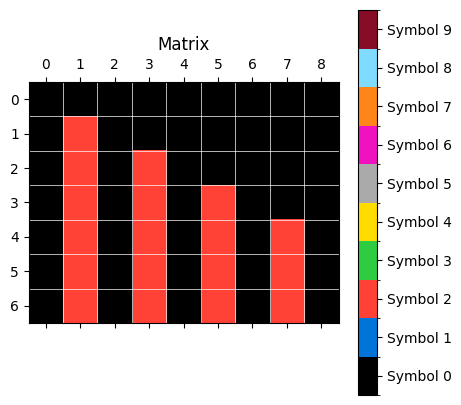

In [16]:
path = "../data/training/ce9e57f2.json"
with open(path,"r") as f:
    data_ce9 = json.loads(f.read())
img_mask = data_ce9["train"][0]["input"]
img_mask = np.array(img_mask)
img_mask.shape
input_img= Image(0,0,9,7,img_mask)
display_matrix(input_img)

In [9]:
# display_matrix(input_img.list_components())

In [10]:
# list_components(input_img)

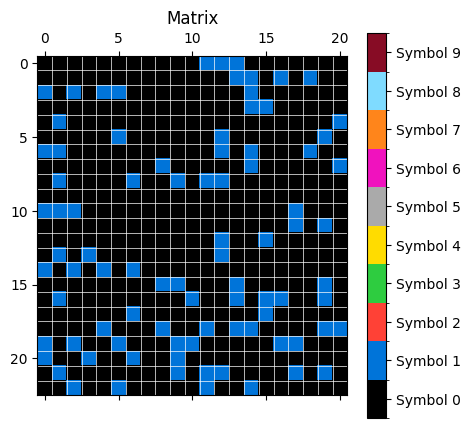

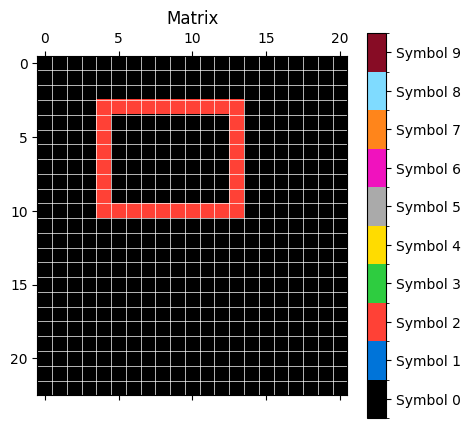

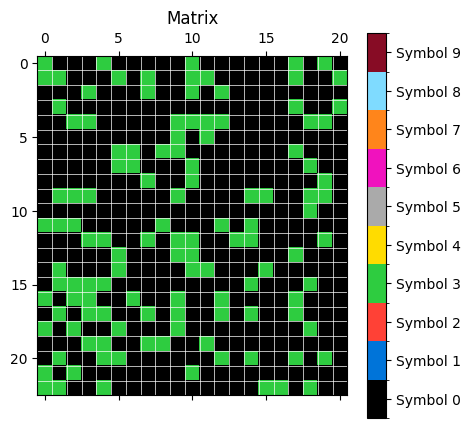

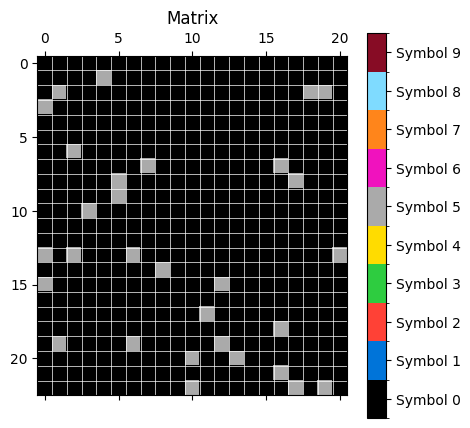

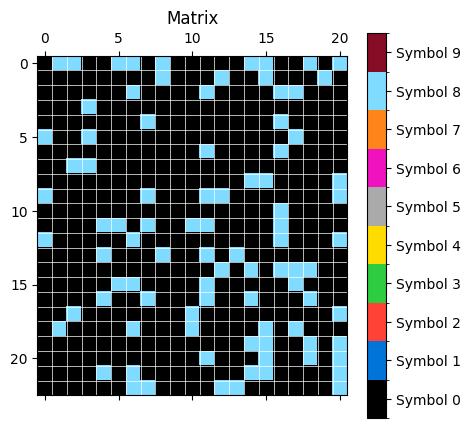

[None, None, None, None, None]

In [11]:
[ display_matrix(i) for i in input_img.list_components("partition")]

In [12]:
parser = Parser()
script = """
count = COUNTCOL 2;
IF count > 2 and count < 10 
    DISPLAY;
ELSE
    SELECT 0 0 4 4;
    FILL 4;
    IF [count] > 3 and [count] < 9 
        DISPLAY;
    ELSE
        SELECT 0 0 4 4;
        FILL 3;
    END
END
WHILE count==3
    DISPLAY;
    count = count +  1;
END 
DESELECT
S = SPLIT DFS
LIST li = []
FOR I IN S:
    APPEND li i COUNT 2
END 
RETURN MAX li
"""

root_node = parser.parse(script)
print(root_node.format())

# Print symbol table contents
print("\nSymbol Table Contents:")
for scope, symbols in parser.symbol_table.scopes.items():
    print(f"Scope: {scope}")
    for name, symbol in symbols.items():
        print(f"  {name}: {symbol.type}")

Node(type=ROOT, children=[
    Node(type=ASSIGN, value={'variable': 'count', 'expression': 'COUNTCOL 2;'}, children=[
        Node(type=FUNCTION, value={'name': 'COUNTCOL', 'args': ['2']}, children=[]),
    ]),
    Node(type=IF, value={'condition': 'count > 2 and count < 10'}, children=[
        Node(type=TRUE_BLOCK, children=[
            Node(type=FUNCTION, value={'name': 'DISPLAY', 'args': []}, children=[]),
        ]),
        Node(type=FALSE_BLOCK, children=[
            Node(type=FUNCTION, value={'name': 'SELECT', 'args': ['0', '0', '4', '4']}, children=[]),
            Node(type=FUNCTION, value={'name': 'FILL', 'args': ['4']}, children=[]),
            Node(type=IF, value={'condition': '[count] > 3 and [count] < 9'}, children=[
                Node(type=TRUE_BLOCK, children=[
                    Node(type=FUNCTION, value={'name': 'DISPLAY', 'args': []}, children=[]),
                ]),
                Node(type=FALSE_BLOCK, children=[
                    Node(type=FUNCTION, val

In [13]:
from dsl_main import CommandMapper
c = CommandMapper(input_img)


In [14]:
i = root_node.children[0]

In [15]:
i.node_type, i.value, i.children

('ASSIGN',
 {'variable': 'count', 'expression': 'COUNTCOL 2;'},
 [Node(type=FUNCTION, value={'name': 'COUNTCOL', 'args': ['2']}, children=[])])

In [40]:
[i.value for i in root_node.children]

[{'variable': 'count', 'expression': 'COUNTCOL 2;'},
 {'condition': 'count > 2 and count < 10'},
 {'condition': 'count==3'},
 {'name': 'DESELECT', 'args': []},
 {'variable': 'S', 'expression': 'SPLIT DFS'},
 {'name': 'li', 'initial_values': []},
 {'iterator': 'I', 'iterable': 'S:'},
 {'name': 'RETURN', 'args': ['MAX', 'li']}]

In [41]:
c.count([2])

18

applying glip


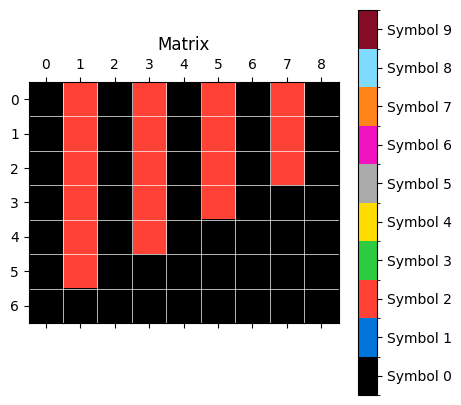

In [42]:


display_matrix(c.flip(["VERTICAL"]))

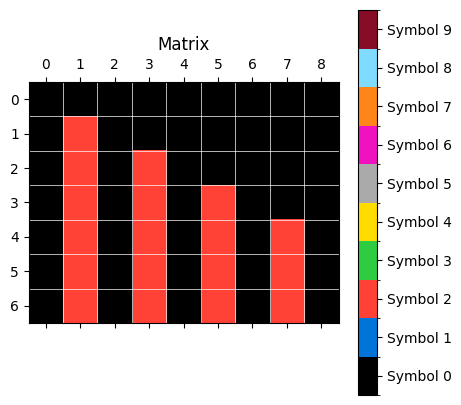

In [43]:
display_matrix(input_img)

In [44]:
from typing import List, Dict, Any
import re
from arclang.image import Image, Point

class ExecutionEngine:
    def __init__(self, input_img):
        self.command_mapper = CommandMapper(input_img)
        self.initial_image = input_img
        self.variables = {}
        self.current_image = input_img

    def execute(self, root_node: Node) -> Image:
        for child in root_node.children:
            self.execute_node(child)
        return self.current_image

    def execute_node(self, node: Node) -> None:
        if node.node_type == 'ASSIGN':
            self.execute_assignment(node)
        elif node.node_type == 'FUNCTION':
            self.execute_function(node)
        elif node.node_type == 'IF':
            self.execute_if(node)
        elif node.node_type == 'LOOP':
            self.execute_loop(node)
        elif node.node_type == 'EMPTY':
            pass
        else:
            raise ValueError(f"Unknown node type: {node.node_type}")

    def execute_assignment(self, node: Node) -> None:
        var_name = node.value['variable']
        expression = node.value['expression']
        
        if node.children and node.children[0].node_type == 'FUNCTION':
            # If the assignment is a function call, execute it and store the result
            self.execute_function(node.children[0])
            self.variables[var_name] = self.current_image
        else:
            # Otherwise, evaluate the expression and store the result
            self.variables[var_name] = self.evaluate_expression(expression)

    def execute_function(self, node: Node) -> None:
        func_name = node.value['name']
        args = node.value['args']
        
        # Replace variable references with their values
        args = [self.evaluate_expression(arg) if isinstance(arg, str) and arg in self.variables else arg for arg in args]
        
        if func_name in self.command_mapper.function_map:
            # Execute the function and update the current image
            self.current_image = self.command_mapper.function_map[func_name](args)
        else:
            raise ValueError(f"Unknown function: {func_name}")

    def execute_if(self, node: Node) -> None:
        condition = self.evaluate_condition(node.value['condition'])
        print(condition)
        if condition:
            self.execute(node.children[0])
        elif len(node.children) > 1:
            self.execute(node.children[1])

    def execute_loop(self, node: Node) -> None:
        loop_type = node.value['type']
        if loop_type == 'FOR':
            self.execute_for_loop(node)
        elif loop_type == 'WHILE':
            self.execute_while_loop(node)
        else:
            raise ValueError(f"Unknown loop type: {loop_type}")

    def execute_for_loop(self, node: Node) -> None:
        var_name = node.value['variable']
        start, end, step = node.value['range']
        for i in range(start, end, step):
            self.variables[var_name] = i
            self.execute(node.children[0])

    def execute_while_loop(self, node: Node) -> None:
        while self.evaluate_condition(node.value['condition']):
            self.execute(node.children[0])

    def evaluate_expression(self, expression: str) -> Any:
        if isinstance(expression, str):
            try:
                return eval(expression, {}, self.variables)
            except:
                return expression  # If it's not a valid Python expression, return as is
        return expression

    def evaluate_condition(self, condition: str) -> bool:
        return bool(self.evaluate_expression(condition))

In [50]:
parser = Parser()
script = """
DISPLAY;
count = COUNTCOL 2;
SELECT 0 0 4 4;
FILL 4;
DISPLAY;
DESELECT;
FLIP HORIZONTAL;
DISPLAY;
"""
root_node = parser.parse(script)


In [51]:
e = ExecutionEngine(input_img)

In [52]:
e.variables

{}

In [53]:
print(root_node.format())

Node(type=ROOT, children=[
    Node(type=FUNCTION, value={'name': 'DISPLAY', 'args': []}, children=[]),
    Node(type=ASSIGN, value={'variable': 'count', 'expression': 'COUNTCOL 2;'}, children=[
        Node(type=FUNCTION, value={'name': 'COUNTCOL', 'args': ['2']}, children=[]),
    ]),
    Node(type=FUNCTION, value={'name': 'SELECT', 'args': ['0', '0', '4', '4']}, children=[]),
    Node(type=FUNCTION, value={'name': 'FILL', 'args': ['4']}, children=[]),
    Node(type=FUNCTION, value={'name': 'DISPLAY', 'args': []}, children=[]),
    Node(type=FUNCTION, value={'name': 'DESELECT', 'args': []}, children=[]),
    Node(type=FUNCTION, value={'name': 'FLIP', 'args': ['HORIZONTAL']}, children=[]),
    Node(type=FUNCTION, value={'name': 'DISPLAY', 'args': []}, children=[]),
])


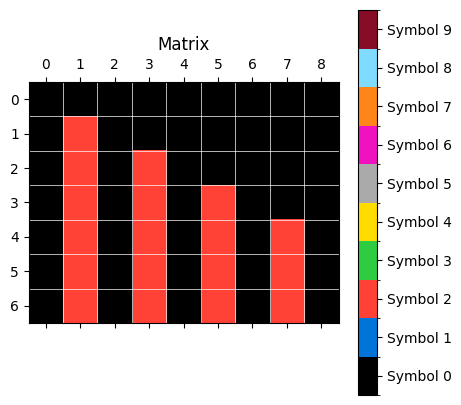

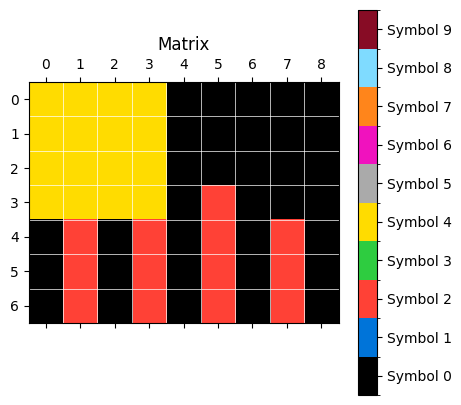

applying glip


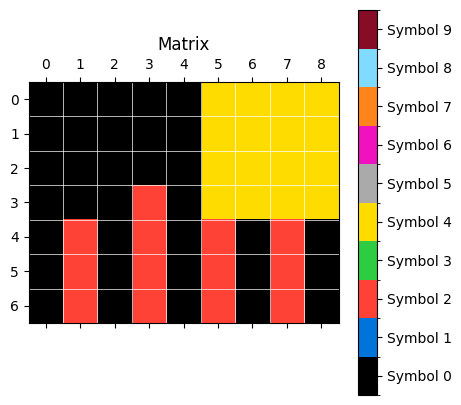

In [54]:
e.execute(root_node)

In [29]:
e.variables

{'count': 18}

In [126]:
c.count([2,input_img])

18

In [26]:
root_node = parser.parse(script)

In [31]:
# [i. for i in root_node.children]

In [15]:

parser = Parser()
script = """
comp = SPLIT
FOR c in split
    DISPLAY c
END
PRINT y;
"""

root_node = parser.parse(script)
print(root_node.format())

# Print symbol table contents
print("\nSymbol Table Contents:")
for scope, symbols in parser.symbol_table.scopes.items():
    print(f"Scope: {scope}")
    for name, symbol in symbols.items():
        print(f"  {name}: {symbol.type}")

Node(type=ROOT, children=[
    Node(type=ASSIGN, value={'variable': 'comp', 'expression': 'SPLIT'}, children=[]),
    Node(type=FOR, value={'iterator': 'c', 'iterable': 'split'}, children=[
        Node(type=LOOP_FOR, children=[
            Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': ['c']}, children=[]),
        ]),
    ]),
    Node(type=FUNCTION_CALL, value={'name': 'PRINT', 'args': ['y']}, children=[]),
])

Symbol Table Contents:
Scope: global
  comp: variable


In [16]:

parser = Parser()
script = """
comp = SPLIT
FOR c in split
    DISPLAY c
END
PRINT y;
"""

root_node = parser.parse(script)
print(root_node.format())

# Print symbol table contents
print("\nSymbol Table Contents:")
for scope, symbols in parser.symbol_table.scopes.items():
    print(f"Scope: {scope}")
    for name, symbol in symbols.items():
        print(f"  {name}: {symbol.type}")

Node(type=ROOT, children=[
    Node(type=ASSIGN, value={'variable': 'comp', 'expression': 'SPLIT'}, children=[]),
    Node(type=FOR, value={'iterator': 'c', 'iterable': 'split'}, children=[
        Node(type=LOOP_FOR, children=[
            Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': ['c']}, children=[]),
        ]),
    ]),
    Node(type=FUNCTION_CALL, value={'name': 'PRINT', 'args': ['y']}, children=[]),
])

Symbol Table Contents:
Scope: global
  comp: variable


In [17]:
parser = Parser()
script = """
DISPLAY;
count = COUNTCOL 2;
DEF calculate(a, b)
    IF [count] > 2 and [count] < 10 
        DISPLAY;
    ELSE
        SELECT 0 0 4 4;
        FILL 4;
    END
END
IF [count > 2 and [count] < 10 
    DISPLAY;
ELSE
    SELECT 0 0 4 4;
    FILL 4;
END

"""

root_node = parser.parse(script)
print(root_node.format())

# Print symbol table contents
print("\nSymbol Table Contents:")
for scope, symbols in parser.symbol_table.scopes.items():
    print(f"Scope: {scope}")
    for name, symbol in symbols.items():
        print(f"  {name}: {symbol.type}")

Node(type=ROOT, children=[
    Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': []}, children=[]),
    Node(type=ASSIGN, value={'variable': 'count', 'expression': 'COUNTCOL 2;'}, children=[]),
    Node(type=FUNCTION_DEF, value={'name': 'calculate', 'params': ['a', 'b']}, children=[
        Node(type=BLOCK, children=[
            Node(type=IF, value={'condition': '[count] > 2 and [count] < 10'}, children=[
                Node(type=TRUE_BLOCK, children=[
                    Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': []}, children=[]),
                ]),
                Node(type=FALSE_BLOCK, children=[
                    Node(type=FUNCTION_CALL, value={'name': 'SELECT', 'args': ['0', '0', '4', '4']}, children=[]),
                    Node(type=FUNCTION_CALL, value={'name': 'FILL', 'args': ['4']}, children=[]),
                ]),
            ]),
        ]),
    ]),
    Node(type=IF, value={'condition': '[count > 2 and [count] < 10'}, children=[
        Node(t

Node(type=ROOT, children=[
    Node(type=ASSIGN, value={'variable': 'count', 'expression': 'COUNTCOL 2;'}, children=[]),
    Node(type=IF, value={'condition': 'count > 2 and count < 10'}, children=[
        Node(type=TRUE_BLOCK, children=[
            Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': []}, children=[]),
        ]),
        Node(type=FALSE_BLOCK, children=[
            Node(type=FUNCTION_CALL, value={'name': 'SELECT', 'args': ['0', '0', '4', '4']}, children=[]),
            Node(type=FUNCTION_CALL, value={'name': 'FILL', 'args': ['4']}, children=[]),
            Node(type=IF, value={'condition': '[count] > 3 and [count] < 9'}, children=[
                Node(type=TRUE_BLOCK, children=[
                    Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': []}, children=[]),
                ]),
                Node(type=FALSE_BLOCK, children=[
                    Node(type=FUNCTION_CALL, value={'name': 'SELECT', 'args': ['0', '0', '4', '4']}, children=[])

In [19]:
parser = Parser()
script = """
WHILE count==3
    DISPLAY;
    count = count +  1;
END 
"""

root_node = parser.parse(script)
print(root_node.format())

# Print symbol table contents
print("\nSymbol Table Contents:")
for scope, symbols in parser.symbol_table.scopes.items():
    print(f"Scope: {scope}")
    for name, symbol in symbols.items():
        print(f"  {name}: {symbol.type}")

Node(type=ROOT, children=[
    Node(type=WHILE, value={'condition': 'count==3'}, children=[
        Node(type=LOOP_WHILE, children=[
            Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': []}, children=[]),
            Node(type=ASSIGN, value={'variable': 'count', 'expression': 'count +  1;'}, children=[]),
        ]),
    ]),
])

Symbol Table Contents:
Scope: global
  count: variable


In [25]:
class ExecutionEngine:
    def __init__(self, image: Image):
        self.image = image
        self.parser = Parser()
        self.mapper = CommandMapper(image)
        self.variable_map = {}
    
    def execute(self, script: str) -> Image:
        commands = self.parser.parse(script)
        print(commands.format())
        return self.image
    
    def execute_commands(self, commands: List[Dict[str, Any]]):
        for command in commands:
            self.execute_command(command)
    
    def execute_command(self, command: Dict[str, Any]):
        if command['type'] == 'ASSIGN':
            self.execute_assignment(command)
        elif command['type'] == 'FUNCTION':
            self.execute_function(command)
        elif command['type'] == 'IF':
            self.execute_if(command)
    
    def execute_assignment(self, command: Dict[str, Any]):
        var_name = command['variable']
        expression = command['expression']
        value = self.evaluate_expression(expression)
        self.variable_map[var_name] = value
    

    def execute_function(self, command: Dict[str, Any]):
        func_name = command['name']
        args = command['args']
        
        if func_name in self.mapper.function_map:
            func = self.mapper.function_map[func_name](args)
            if func_name in RETURN_FUNCTIONS:
                result = func(self.image)
                print(f"Function {func_name} returned: {result}")
                return result
            else:
                self.image = func(self.image)
        else:
            raise ValueError(f"Unknown function: {func_name}")
 
                
    def execute_if(self, command: Dict[str, Any]):
        condition = command['condition']
        if self.evaluate_condition(condition):
            self.execute_commands(command['true_block'])
        elif command['false_block']:
            self.execute_commands(command['false_block'])



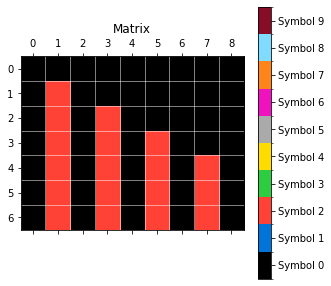

In [26]:
path = "/Users/saisur/Desktop/projects/arc/ARC-AGI/data/training/ce9e57f2.json"
with open(path,"r") as f:
    data_ce9 = json.loads(f.read())
img_mask = data_ce9["train"][0]["input"]
img_mask = np.array(img_mask)
img_mask.shape
input_img= Image(0,0,9,7,img_mask)
display_matrix(input_img)

In [27]:
engine = ExecutionEngine(input_img)
engine 

In [28]:
engine.execute(script)

Node(type=ROOT, children=[
    Node(type=ASSIGN, value={'variable': 'count', 'expression': 'COUNTCOL 2;'}, children=[]),
    Node(type=IF, value={'condition': 'count > 2 and count < 10'}, children=[
        Node(type=TRUE_BLOCK, children=[
            Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': []}, children=[]),
        ]),
        Node(type=FALSE_BLOCK, children=[
            Node(type=FUNCTION_CALL, value={'name': 'SELECT', 'args': ['0', '0', '4', '4']}, children=[]),
            Node(type=FUNCTION_CALL, value={'name': 'FILL', 'args': ['4']}, children=[]),
            Node(type=IF, value={'condition': '[count] > 3 and [count] < 9'}, children=[
                Node(type=TRUE_BLOCK, children=[
                    Node(type=FUNCTION_CALL, value={'name': 'DISPLAY', 'args': []}, children=[]),
                ]),
                Node(type=FALSE_BLOCK, children=[
                    Node(type=FUNCTION_CALL, value={'name': 'SELECT', 'args': ['0', '0', '4', '4']}, children=[])

In [ ]:
parser = Parser()
script = """
count = COUNTCOL 2;
IF [count] > 2 and [count] < 10 
    DISPLAY;
ELSE
    SELECT 0 0 4 4;
    FILL 4;
END